<h1><center>Projet Qualité des données : WebScrapping</center></h1>
<center>Groupe 11 : Riccardo FIGLIOZZI - Giovanni Ivan INDIVERI - Xinqiang LIU - Chloé PATRAS</center>


In this lab assignment, you will improve your skills in scraping data from web pages, organizing the data in a desired format. To do so, we will use data that is provided by the Indeed company via their web pages.


You task will be to exectute the following blocks of code and try to understand what is happening after each line of the code. You will have to answer several questions to show your understanding.

Let us start with importing of the relevant packages.

Warning: I am using Python 3 for this lab assignment. If you are using Python 2, then some libraries may need to be changed., e.g., urllib -> urlib2.

In [ ]:
import urllib.request
import urllib.error
import bs4 #this is beautiful soup

import time
from pandas import Series
import pandas as pd
from pandas import DataFrame
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

As you see, you imported the package called `re`, which supports regular expression operations. You have already used the other packages. 

The following block will access and load the contents of an Indeed.com web page. It will probably give you a warning -- please ignore it.

In [ ]:
# Fixed url for job postings containing data scientist
url = 'https://www.indeed.fr/jobs?q=data+scientist&l=%C3%8Ele-de-France'
# read the website
source = urllib.request.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source)

** Question 1**:
 * What kind of page did you land on? Explain in a few sentences what is the content of this page.
 * What does the "?" and "&" in the url mean?
 * Explore the content of the web page. If you are using Firefox, open the page Inspector to understand how the underlying html code relates to the displayed content.
 * What pieces of the html code are responsible for showing the job title, company name, and job location?
 
The following block of code will figure out how many job ads are there for jobs that contain "data scientist' in the job title.

**Reponse**
1. Indeed est un site web pour rechercher des travails, il est possible de spécifier le nom du travail, ou chercher et c’est aussi possible d’ajouter autres critères.

2. le ? est utilisé pour spécifier des paramètres, & c’est le second paramètre.
3. The title of the job is inside a "h2 class='title'";
	The company name is related to a "span class='company'" inside two "div" under the "h2"
	The job location is given by " "div class="location accessible-contrast-color-location">Asnières-sur-Seine (92)" after the company name.


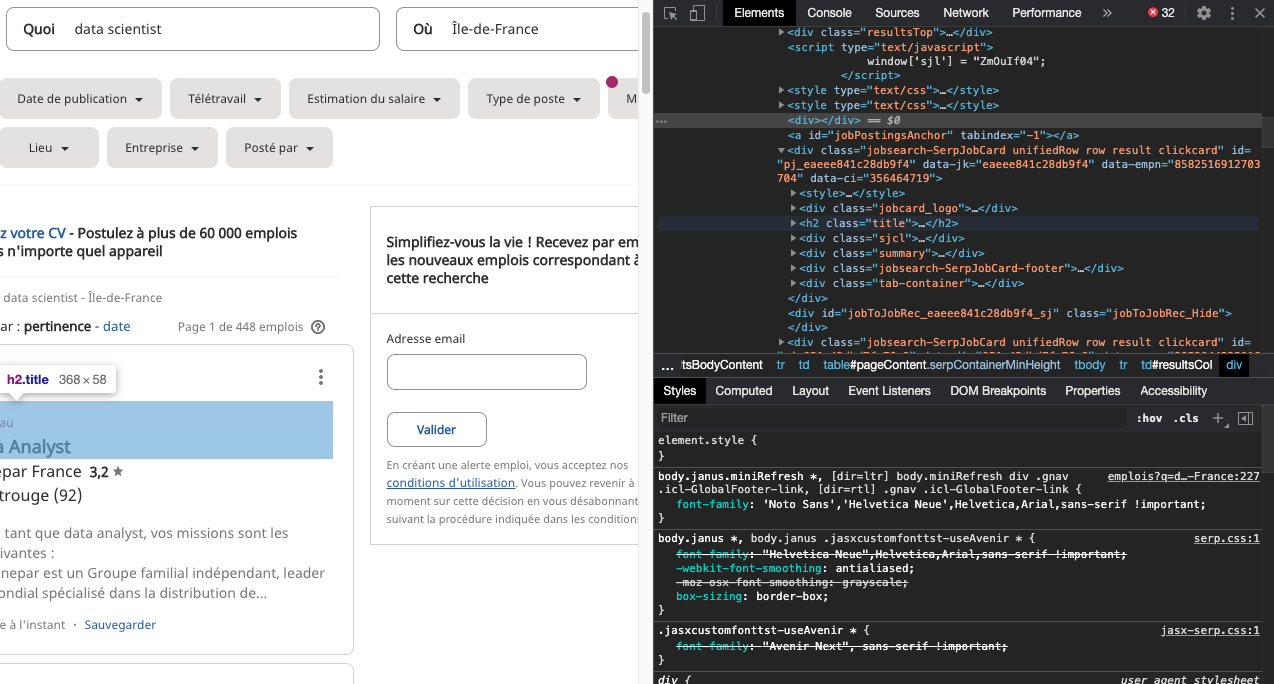

In [ ]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCountPages').contents[0]
job_count_string = job_count_string.split()[-2]
print(("Search yielded %s hits." % (job_count_string)))

# not that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], list(range(len(job_count_digits))))])

print(job_count)

Search yielded 440 hits.
440


** Question 2**:
* What does the "find(id = 'searchCountPages')" in the first line mean?
* What does the second line do?

**Question 3**: 
* Write a piece of code that finds the Salary Estimate object on the page


**Reponse**
1. sélectionne l'élément correspondant á l’id “searchCountPages” qui indique le nombre de la page sur le nombre des emplois disponible ex. 3 des 400.
2. il fait un split et il prend le pénultième élément . 

In [ ]:
spans = bs_tree.find_all('span', attrs={'class':"salaryText"})
for span in spans:
    print(span.string)


30 000 € - 40 000 € par an

3 043 € - 3 719 € par mois

50 000 € - 65 000 € par an

30 000 € - 32 000 € par an

2 981 € - 3 644 € par mois


The following piece of code allows you to find the links to all the job ads on the page.

In [ ]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
for i in range(2): #do range(num_pages) if you want them all
    url = 'https://www.indeed.fr/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=' + str(i*10)
    html_page = urllib.request.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')

    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if str(jp.get('class')).find('row result')]
    
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    
    # go after each link
    for id in job_ids:
        if (id != None):
            job_links.append(base_url + '/rc/clk?jk=' + id)

    time.sleep(1)

print("We found a lot of jobs: ", len(job_links))

We found a lot of jobs:  30


**Question 4**:
* explain why is `url` (first line in the for loop) defined as it is. What page are you landing at when `i = 3`?
* What does command `bs_tree.find(id = 'resultsCol')` do?
* What does command `''.join(jp.get('class'))` do?
* Explain the properties and content of `job_links`

**Question 5**:
* Reuse the code above to find links to the first 200 listed data science jobs

The following piece of code accesses and grabs the content of all ads in the `job_links` and extracts all the human-readable text tokens. Then, it counts on how many pages are words `mapreduce`, `spark`, and `visualization` used. It might take a few seconds to execute.

**Reponse**
1. dans ce url il y a aussi le paramètre start, ca permettre d’afficher un page specifique des annonces. Avec i = 3 on a start=30,  ca sera la page 4 des annonces
2. bs_tree.find(id = 'resultsCol'), cherche dans la page html l’id 'resultsCol’ parce que il est la partie de la page qui contient les annonces disponible
3. .join(jp.get('class')) prendre la classe où il trouve 'row result'
4. il y a le url base 'http://www.indeed.com' , après on ajoute href '/rc/clk?jk=' et finalement l’id qui identifie une annonce('data-jk’)
5. change range

In [ ]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
for i in range(14): #do range(num_pages) if you want them all
    url = 'https://www.indeed.fr/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=' + str(i*10)
    html_page = urllib.request.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')

    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if str(jp.get('class')).find('row result')]
    
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    
    # go after each link
    for id in job_ids:
        if (id != None):
            job_links.append(base_url + '/rc/clk?jk=' + id)

    time.sleep(1)

print("We found a lot of jobs: ", len(job_links))

We found a lot of jobs:  200


In [ ]:
skill_set = {'hadoop':0, 'spark':0, 'python':0}
counter = 0
for link in job_links:
    counter +=1  
    
    try:
        html_page = urllib.request.urlopen(link).read()
    except urllib.error.HTTPError:
        continue
    except urllib.error.URLError:
        continue
    except socket.error as error:
        print("Connection closed")
        continue

    try:
      html_text = re.sub("[^a-z.+3]"," ", html_page.decode('utf-8').lower()) # replace all but the listed characters
    except UnicodeDecodeError:
      continue

        
    for key in list(skill_set.keys()):
        if key in html_text:  
            skill_set[key] +=1
    if counter % 5 == 0:
        print(len(job_links) - counter)
        print(skill_set)
            
print(skill_set)

195
{'hadoop': 0, 'spark': 1, 'python': 3}
190
{'hadoop': 0, 'spark': 2, 'python': 5}
185
{'hadoop': 1, 'spark': 3, 'python': 8}
180
{'hadoop': 1, 'spark': 3, 'python': 10}
175
{'hadoop': 1, 'spark': 4, 'python': 14}
170
{'hadoop': 1, 'spark': 4, 'python': 17}
165
{'hadoop': 3, 'spark': 7, 'python': 22}
160
{'hadoop': 3, 'spark': 8, 'python': 25}
155
{'hadoop': 3, 'spark': 8, 'python': 27}
150
{'hadoop': 5, 'spark': 11, 'python': 32}
145
{'hadoop': 5, 'spark': 12, 'python': 34}
140
{'hadoop': 5, 'spark': 13, 'python': 37}
135
{'hadoop': 5, 'spark': 13, 'python': 41}
130
{'hadoop': 7, 'spark': 14, 'python': 44}
125
{'hadoop': 9, 'spark': 16, 'python': 48}
120
{'hadoop': 10, 'spark': 17, 'python': 51}
115
{'hadoop': 10, 'spark': 18, 'python': 55}
110
{'hadoop': 10, 'spark': 19, 'python': 57}
105
{'hadoop': 10, 'spark': 19, 'python': 61}
100
{'hadoop': 12, 'spark': 21, 'python': 66}
95
{'hadoop': 15, 'spark': 23, 'python': 70}
90
{'hadoop': 17, 'spark': 25, 'python': 74}
80
{'hadoop': 18,

** Question 6**
* What does the `re.sub()` do in the above code? To answer this, you will have to go to the documentation of the regular expression package (find it on web).
* What is the meaning of `[^a-z.+3]`?
* What is the content of `skill_set`?

The following piece of code plots the counts of different skills in the processed ads.

**Reponse**
1. re.sub est utile pour remplacer a string avec un string donnée
2. il indique la partie de string à remplacer, a partir de a à z pour une occcurance de trois fois
3. c’est un dict qui contient des skill et combien de fois il sont requête 

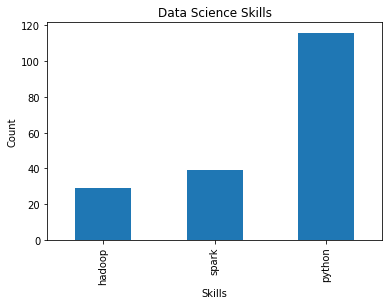

In [ ]:
pseries = pd.Series(skill_set)
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

**Question 7**:
- rerun the code to find the counts of the 3 data science skills on the first 200 job ads

## Data analysis of the housing market in the Paris area 

In the first part of the lab, you created `skill_set` dictionary that counts occurences of 3 important data science skills of the jobs in Ile de France. In the second part of this lab, your task will be to create a padas 'DataFrame' object containing information about the flats/houses that are available for rent in the paris area. For each offer, you will have to create columns such as: 
- Location
- Surface
- Number of rooms
- ...

To do so, we will be using seloger.com. Unlike the first part, where you were provided with snippets of codes that help you get familiarized with Web Scrapping skills, in this part you are left on your own to figure out how to do so. You can reduce your search to a specific area of paris, e.g., Paris 9, and for specific range of rent [700 euros,800 euros].

https://www.seloger.com/list.htm?projects=1&types=1,2&places=[{div:2238}]&price=700/800&enterprise=0&qsVersion=1.0

Note: I obtained the above URL by simply using the web page as a human via a browser, and specifying the criteria I needed to via the web form provided by seloger.com


### Deliverable: the modified .ipynb file that contains the answers to the questions

In [303]:
import requests
from bs4 import BeautifulSoup

In [407]:
param = ['href','Price (€)', 'Number of rooms', 'Dimension (mq)', 'Location'] 

In [408]:
house_df = pd.DataFrame(columns = param)

In [409]:
count = 0
for i in range(1,12): 
    URL = "https://www.logic-immo.com/location-immobilier-paris-16e-75016,paris-15e-75015,23595_2,23594_2/options/groupprptypesids=1/page="+str(i)+"/pricemax=1000"
    
    r = requests.get(URL) 
    soup = BeautifulSoup(r.content, 'html.parser') 
    
    for line in soup.find_all('div', {'class':"offer-details-wrapper"}):
      if line.find(class_='offer-link'):
        href = line.find('a', {'class':"offer-link"})['href']
        price = line.find('p', {'class':"offer-price"}).span.string.replace("€","")
        try :
          n_rooms = line.find('span', {'class':"offer-rooms-number"}).string
        except AttributeError :
          n_rooms = "Indisponible"
        try :
          mq = line.find('span', {'class':"offer-area-number"}).string
        except AttributeError :
          mq = "Indisponible"
        try :
          place = line.find('span', {'class':"offer-details-location--locality"}).string
        except AttributeError :
          place = line.find('div', {'class':"offer-details-location"}).text
          place = place.strip()
        house_df.loc[count] = [href,price, n_rooms, mq, place]
        count +=1

In [410]:
house_df

,href,Price (€),Number of rooms,Dimension (mq),Location
0,https://www.logic-immo.com/detail-location-62b...,850,2,31,Paris 16e \n(75016) \nVoir sur la carte
1,https://www.logic-immo.com/detail-location-269...,830,1,20,Paris 15 (75015)
2,https://www.logic-immo.com/detail-location-528...,850,1,19,Paris 15 (75015)
3,https://www.logic-immo.com/detail-location-e70...,850,1,25,Paris 16 (75016)
4,https://www.logic-immo.com/detail-location-f56...,890,1,24,Paris 16 (75016)
...,...,...,...,...,...
211,https://www.logic-immo.com/detail-location-863...,1 000,1,25,Paris 15 (75015)
212,https://www.logic-immo.com/detail-location-4c1...,1 000,2,34,Paris 15 (75015)
213,https://www.logic-immo.com/detail-location-683...,1 000,1,31,Paris 15 (75015)
214,https://www.logic-immo.com/detail-location-bb4...,1 000,1,25,Paris 15 (75015)


In [411]:
for i in range(len(house_df)):
  if '75015' in house_df.iloc[i]['Location']: 
    house_df.iloc[i]['Location'] = "Paris 15 (75015)"

In [412]:
for i in range(len(house_df)):
  if '75016' in house_df.iloc[i]['Location']: 
    house_df.iloc[i]['Location'] = "Paris 16 (75016)"

In [413]:
house_df.to_csv("house.csv", header=True)